<a href="https://colab.research.google.com/github/Vibertexs/Tensorflow-Projects/blob/main/Bilal_Offensive_Tweet_Detection_with_BERT_(Student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspirit AI Notebook Made During Course

<center><img src="https://imgur.com/EE29PVd.jpg" width="1000px"></center>

## Introduction

In this notebook, we will build a text classification model based on *BERT* (a transformer model) to automatically flag hateful or offensive tweets. *BERT* is part of a larger category of language models called "transformers" which greatly outperform RNNs and LSTMs on most language tasks. So hopefully, we can use *BERT* to create an extremely accurate toxic tweet detection model (which does even better than LSTMs!). So let's get started!

Here are some resources to understand *BERT* and transformers better...


1. [The Illustrated BERT](http://jalammar.github.io/illustrated-bert/)
2. [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
3. [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)




**Before starting, set your runtype type to GPU!**

Then start installing these libraries since it may take time.

## Install additional libraries

We need to install a few additional libraries to run this notebook.


In [ ]:
#@title Run: Import Libraries and Data
"""
Install necessary libraries and functions
"""
 
!pip install -q colorama
!pip install -q sentencepiece
!wget --quiet https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201-5/State%20of%20the%20Art%20NLP/tokenization.py

"""
Import libraries
"""

import os
import gc
import io
import zipfile
import requests
import warnings as wrn
wrn.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tokenization
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

"""
Define data-loading function
"""

data_link = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201-5/State%20of%20the%20Art%20NLP/labeled_data.csv'

def get_dataset():
    return pd.read_csv(io.StringIO(requests.get(data_link).text))

"""
Load the dataset and create a 'label' column
"""

train_df = get_dataset()
del train_df['Unnamed: 0']
train_df['label'] = np.int32(train_df['class'] != 2)

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(30, 15), facecolor='#e6e6e6')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#f8f8f8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('Model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'])

## Outline

* Visualize and analyze the training data.
* Implement a baseline model using bag of words and logistic regression.
* Understand BERT tokenization and do the necessary preprocessing.
* Build a classification model that uses the BERT language model to encode the text in each tweet.
* Analyze the performance and contrast it with the baseline.

## Exercise 1

Please print out our dataset, `train_df`:

In [ ]:
train_df

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,6,0,6,0,1,youu got wild bitches tellin you lies,1


**What information** does each column give us?

How might platforms like **[CrowdFlower](https://visit.figure-eight.com/People-Powered-Data-Enrichment_T)** be useful for ML?

* `count`: number of CrowdFlower users who coded each tweet
* `hate_speech`: number of CrowdFlower users who judged the tweet to be hate speech
* `offensive_language`: number of CrowdFlower users who judged the tweet to be offensive
* `neither`: number of CrowdFlower users who judged the tweet to be neither offensive nor hate speech
* `class`: class label for majority of CrowdFlower users. 0 = hate speech, 1 = offensive language, 2 = neither
* `tweet`: the actual tweet
* `label`: 0 = good tweet (no hate speech or offensive language), 1 = bad tweet (hate speech and/or offensive language).  Which other column does this remind you of?

(Check out [this article](https://www.bbc.com/worklife/article/20190829-the-ghost-work-powering-tech-magic) to learn about ethical problems around the "ghost worker economy" powering platforms like CrowdFlower!)

## Visualize the training data
These tweets get nasty, so we won't be looking through the texts together. If you choose to explore on your own, **please be mindful** - your classmates probably don't want to see hate speech on your screen share!

Instead, we'll do some basic visualization to understand our dataset better.


**What do these plots tell us about our data?**

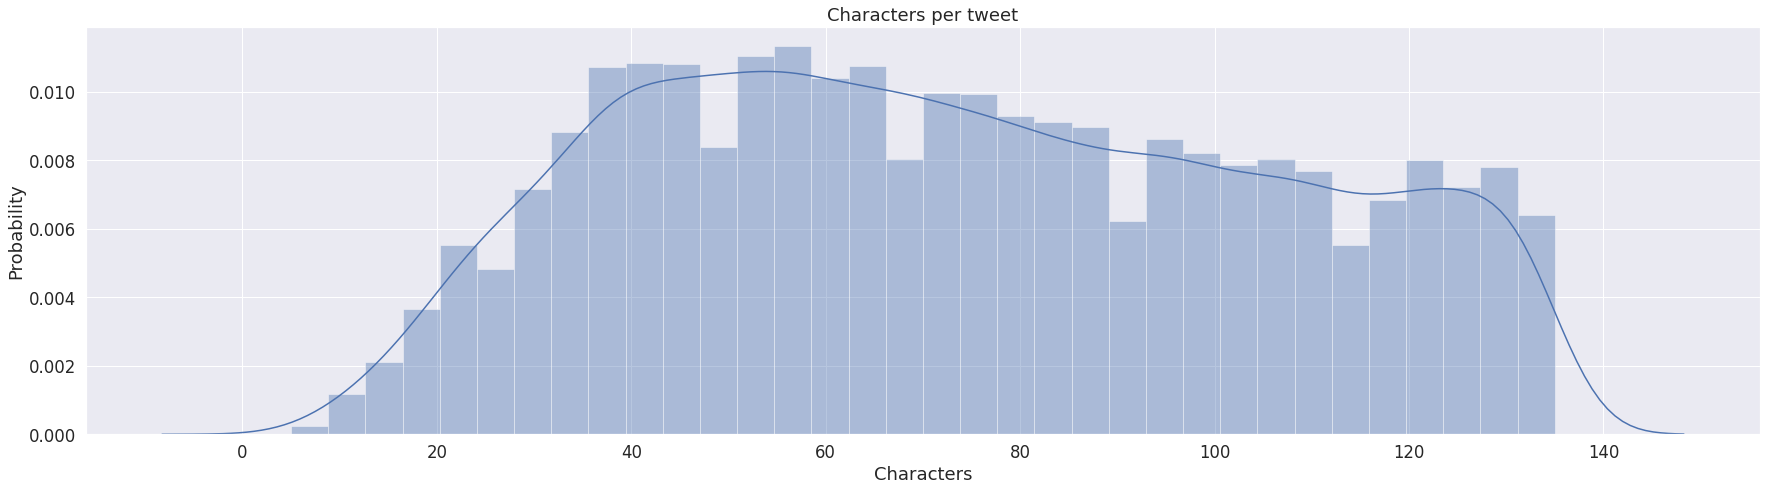

In [ ]:
#@title Characters per tweet
"""
Visualize the distribution of the number of characters per tweet
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
fig = sns.distplot(sorted(train_df.tweet.apply(len))[:21000], color='b')
fig.set(title='Characters per tweet', xlabel='Characters', ylabel='Probability')
plt.show('--------------------------------------------------------------------')

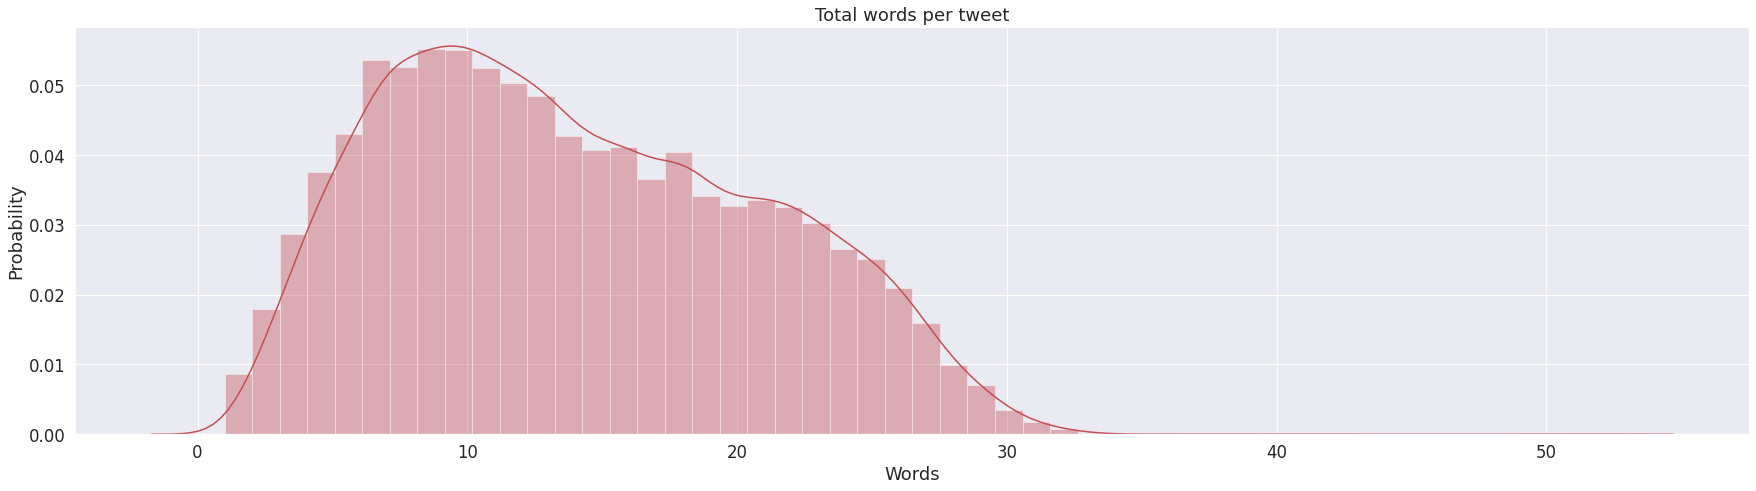

In [ ]:
#@title Words per tweet
"""
Visualize the distribution of the number of words per tweet
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
words = lambda x: len(x.split())
fig = sns.distplot(sorted(train_df.tweet.apply(words)), color='r')
fig.set(title='Total words per tweet', xlabel='Words', ylabel='Probability')
plt.show('----------------------------------------------------------------')

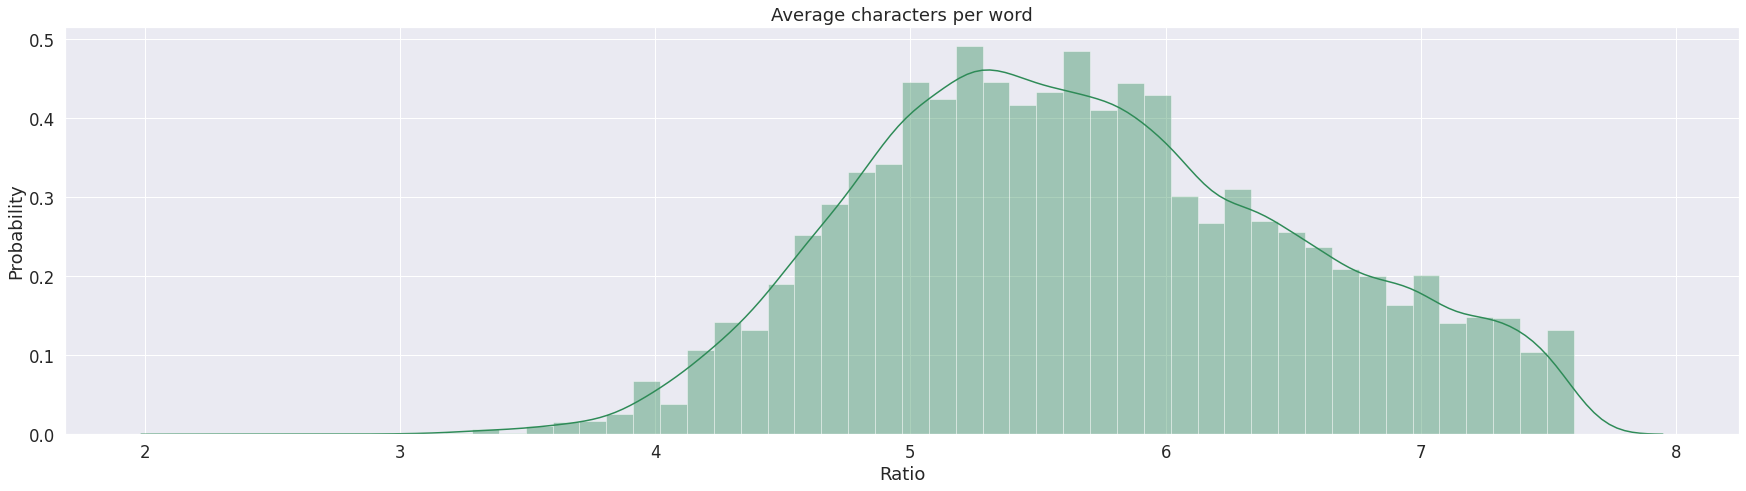

In [ ]:
#@title Characters per word
"""
Visualize the distribution of the number of characters per word
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
ratio = lambda x: len(x)/len(x.split())
fig = sns.distplot(sorted(train_df.tweet.apply(ratio))[:21000], color='seagreen')
fig.set(title='Average characters per word', xlabel='Ratio', ylabel='Probability')
plt.show('----------------------------------------------------------------------')

### Exercise 2

What percent good/bad tweets do we have?

In [ ]:
#YOUR CODE HERE
x=0
train_df.shape
# 24783 rows

train_df["label"].sum()/train_df.shape[0]

# for i in train_df["class"]:
#     if i!=2:
#         x+=1
# print("Percentage of hate/offensive tweets:" , ((x/train_df.shape[0])*100))


0.8320219505306057

**Discuss:**
1. Is the dataset balanced?
2. What baseline accuracy could you get with no effort?

#Implementing a Baseline Model

In this notebook, we are going to see the power of using the BERT language model to represent words and sentences.  To really understand BERT's power, we will contrast by first implementing a baseline model: logistic regression where words are represented via Bag of Words encoding.

##Exercise 3

Create two variables, `sentences` and `labels`, by extracting the appropriate column from the training dataframe.

In [ ]:
#YOUR CODE HERE
sentences = train_df["tweet"].values
labels = train_df["label"].values

Now, run the code below to create our bag-of-words representation:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=1000)

#build bag of words encoding for training data
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)


##Exercise 4

Build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model (imported above from sklearn) with `max_iter=5`. Then train and score it on the training and test data!

In [ ]:
#YOUR CODE HERE
model = LogisticRegression(max_iter=5)
model.fit(X_train,labels_train)
# model.score(X_test,labels_test)
print("Training Accuracy:", model.score(X_train,labels_train))
print("Testing Accuracy:", model.score(X_test,labels_test))

Training Accuracy: 0.8939271663472208
Testing Accuracy: 0.881783336695582


**Are you pleased with your results?** How could we do better?

#Using BERT

Let's load the pretrained BERT model from TensorFlow Hub.

*TensorFlow Hub* is a large repository of already trained models that can be used by anyone with one line of code. Here, we retrieve the BERT-large (24 encoders!) model from *TensorFlow Hub* to build our own text classification model. *TensorFlow Hub* also includes several other models for language and vision tasks.  

This is making use of the idea of **transfer learning**: it is unrealistic for us to train such a huge model each time, so we can obtain a base model and then build on top of it.  This is very similar to when we fine-tuned gpt2! 

### Exercise 5

Let's fetch a pre-trained Keras layer from the hub using this [documentation](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer).  **Get the handle by concatenating the hub url and id, and remember that we want to do additional training**!  All other parameters can be left as the default.

In [ ]:
#Load the BERT model from TensorFlow Hub and generate a vocabulary file

hub_url = 'https://tfhub.dev/tensorflow/'
hub_id = 'bert_en_uncased_L-24_H-1024_A-16/1'
bert_layer = hub.KerasLayer(hub_url+hub_id, trainable=True)

## Preprocessing

To get our data ready for BERT, we'll have to get it into the right format.

#### **Special Tokens** ####

`[CLS]` token marks the beginning and a `[SEP]` marks the end of a given sequence 

During pre-training, BERT uses `[CLS]` for sequence classification and  `[SEP]` a separator for next sentence prediction.

```
I like to draw  --> [CLS] I like to draw [SEP]
```



#### **Sentence Length** ####

The sentences in our dataset have varying lengths; however, we have to pad the shorter sentences so that the input we give BERT is a perfectly rectangular shape.

```
[CLS] I like to draw [SEP] --> [CLS] I like to draw [SEP] [PAD] [PAD]
```

**Discuss: How do we know how many PAD tokens to add?**


### Define the tokenizer

Next, we define our "tokenizer", which essentially converts tweets into a vectors of tokens.

In [ ]:
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#Define the tokenizer to convert tweets into token vectors
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Let's test it out!

In [ ]:
tokenizer.tokenize("This is a sentence")

['this', 'is', 'a', 'sentence']

#### Exercise 6: Preparing our Text

In this exercise, we will go step-by-step to write a function that takes in a sentence, `text`, as well as a desired `max_length`, and:

1. Uses the BERT Tokenizer to tokenize `text`.
2. Adds the `[CLS]` and `[SEP]` tokens on either end of `text`.
3. Finds the length of the sequence
3. Calculates how many padding tokens are needed (don't actually add the padding)
4. Converts the sequence tokens to numerical ids (hint: use a method of the `tokenizer`!



The first thing we need to do is tokenize our sequence. Remember, at the end of the day, all sentences we feed into our model need to be of the same length (in this case, `max_length`) so that means truncating sentences that are too long (which we'll do in this function) and padding sentences that are too short (which we'll do later).

In the code block below, use the BERT Tokenizer to tokenize `text` and add the `[CLS]` and `[SEP]` tokens to the beginning and end of the sentence, respectively. Make sure that you truncate the sentence so that it is at most `max_length` tokens long **including** the `[CLS]` and `[SEP]` tokens. 

In [ ]:
def tokenize_sequence(text, tokenizer, max_length):
  #YOUR CODE HERE
  sequence = tokenizer.tokenize(text)
  x=max_length-2
  sequence = ["[CLS]"] + sequence[:x] + ["[SEP]"]
  
  #END CODE
  return sequence

Try out your function below. Make sure you have the `[CLS]` and `[SEP]` tokens where they belong, and test with different values of `max_length` to make sure you're truncating correctly!

In [ ]:
text = "Make sure your function works correctly here!"
max_length = 7

print(tokenize_sequence(text, tokenizer, max_length))

['[CLS]', 'make', 'sure', 'your', 'function', 'works', '[SEP]']


Once you have that working, add a few lines of code to the function below so that it will return the sequence, `input_ids` (a list of the tokens converted to numerical IDs), `seq_length` (the length of the sequence without padding), and `pad_length` (the number of `[PAD]` tokens we will have to add to the sequence).


In [ ]:
def get_input_tokens(text, tokenizer, max_length):
  sequence = tokenize_sequence(text, tokenizer, max_length)
  seq_length = len(sequence)
  pad_length = max_length-seq_length
  input_ids = tokenizer.convert_tokens_to_ids(sequence)
  return sequence, input_ids, seq_length, pad_length

#### Tokenization Demo!

Let's try out your function! What's the role of each output?

In [ ]:
sample_tweet = "You can replace this with any string!" ##try any string!
sequence, input_tokens, seq_length, pad_length = get_input_tokens(sample_tweet, tokenizer, len(sample_tweet)+2)
for a, b in zip(sequence, input_tokens):
  print(str(a) + '\t' + str(b))

[CLS]	101
you	2017
can	2064
replace	5672
this	2023
with	2007
any	2151
string	5164
!	999
[SEP]	102


**What is BERT Tokenizer doing?**

If you see words split up, it's due to BERT's [subword tokenization](https://www.thoughtvector.io/blog/subword-tokenization/) - check it out!

###Attention Masks

Attention Mask is an array of 1s and 0s indicating which tokens are padding and which aren't. 

```
[CLS] I like to draw [SEP] [PAD] [PAD] --> 1 1 1 1 1 1 0 0
```

**Given a tokenized sentence, how would you determine the attention mask?**





We'll use this function to get encodings and masks for all our tweets, using the function you wrote. 

**Check out this function if you want, but no need to understand it line-by-line!**

In [ ]:
def bert_encode(texts, tokenizer, max_length=32):
    all_masks, all_tokens = [], []
    
    for text in tqdm(texts):
        # use your function from above to get the token ids for the words in each tweet
        sequence, input_tokens, seq_length, pad_length = get_input_tokens(text, tokenizer, max_length)

        # pad the sequences and add the attention masks 
        # (to pay attention to the relevant tokens in the tweet)
        input_tokens += [0] * pad_length
        input_pad_masks = [1] * seq_length + [0] * pad_length
        all_tokens = all_tokens + [input_tokens]
        all_masks = all_masks + [input_pad_masks]
    
    return np.array(all_tokens), np.array(all_masks), np.zeros_like(all_tokens)

#Train your model

### Exercise 7

Now, let's prepare our input using our *bert_encode* function. 32 works well for the max length.

In [ ]:
#Get the training features and labels

train_labels = train_df.label.values.reshape(-1, 1)
train_input = None ###YOUR CODE HERE

Now, we can define our BERT-based model! We'll use a BERT-large backbone followed by a 1-neuron dense layer, and finally sigmoid activation to generate a probability (of a tweet being offensive).

**Check out the code if you're curious:**

In [ ]:
# Define a function to build a text classification model with a BERT backbone

def build_bert_model(bert_layer, max_len):
    word_ids = Input(shape=(max_len,), dtype=tf.int32)
    input_mask = Input(shape=(max_len,), dtype=tf.int32)
    segment_ids = Input(shape=(max_len,), dtype=tf.int32) #Just zeros
    _, bert_sequence_output = bert_layer([word_ids, input_mask, segment_ids])

    #What's the role of each layer?
    clf_output = bert_sequence_output[:, 0, :]
    output_layer = Dense(1, activation='sigmoid') #Why 1?
    output = output_layer(clf_output)
    return Model(inputs=[word_ids, input_mask, segment_ids], outputs=output)

### Exercise 8

Finally, we can create our model and compile it with an optimizer, loss function, and metric! 

1. Define the BERT-based model.
2. [Compile](https://keras.io/api/models/model_training_apis/#compile-method) it with:

> a. [ADAM optimizer](https://keras.io/api/optimizers/)

> b. `binary_crossentropy` loss

> c. accuracy as an evaluation metric

> Note: any other parameters you see in the documentation for compile are optional.

3. Check out the [model summary](https://keras.io/api/models/model/#summary-method).

In [ ]:
#YOUR CODE HERE

## Exercise 9

We now train the model we built on Colab's free GPU! Try a batch size of 64, a validation split of 0.2, and 2 epochs.

(It will take ~4 minutes per epoch to train. You can check out [AI Dungeon](https://play.aidungeon.io) while you're waiting!)

In [ ]:
"""
Train the model on a GPU using model.fit() 

Five parameters:
1. inputs
2. labels
3. epochs=?
4. validation_split=?
5. batch_size=?
6. shuffle=False

"""

train_history = None ### your code here

# Visualize the model's performance

The model has now finished training! We will now visualize the model's performance with some simple plots.

In [ ]:
#@title Metrics vs. Epochs
display_training_curves([0.43] + train_history.history['loss'], [0.43] + train_history.history['val_loss'], 'Loss', 211)
display_training_curves([0.85] + train_history.history['accuracy'], [0.85] + train_history.history['val_accuracy'], 'Accuracy', 212)

**Discuss:**

1. What do the above plots show us?  
2. Why do the loss and accuracy plots look like mirrors (inverse relation)?
3. What is the difference between training and validation accuracy?  Why are they so far apart at Epoch 1 but not at Epoch 2?
4. When do the training and validation loss "converge"?
5. Is it better for validation accuracy to be higher or lower than the training accuracy?
6. How does this relate to the idea of "overfitting"?

**Overall, how did BERT do compared to our baseline model?** Are you surprised about the high accuracy after only 1 epoch? 



**As a next step**, consider changing the architecture stacked on top of BERT to see if we can fine-tune our model even more!

#Discussion

BERT's a complex model, and it takes time to train it and set it up!

Based on what you've seen, **is it worth it**? Is the accuracy good enough to use? 

What are the pros and cons of automatically detecting toxic speech in general?

Check out the [Allen Institute Demo](https://toxicdegeneration.allenai.org/) for an interactive exploration of how models learn to **create** toxic speech! 
